## 0. Описание задачи.

Автомобильная компания планирует выйти на новые рынки со своими существующими продуктами. После интенсивного маркетингового исследования, они пришли к выводу, что поведение нового рынка аналогично их существующему рынку.

На своем существующем рынке, команда продаж разделила всех клиентов на 4 сегмента (A, B, C, D). Затем они провели сегментированный охват и коммуникацию для различных сегментов клиентов. Эта стратегия отлично себя зарекомендовала, и они планируют использовать ту же стратегию на новых рынках.

Вам необходимо помочь менеджеру предсказать правильную группу новых клиентов.

### Описание признаков
<p>ID | Уникальный идентификатор
<p>Gender | Пол клиента
<p>Ever_Married | Семейное положение клиента
<p>Age | Возраст клиента
<p>Graduated | Получил ли клиент образование
<p>Profession | Профессия клиента
<p>Work_Experience | Опыт работы в годах
<p>Spending_Score | Балл трат клиента
<p>Family_Size | Количество членов семьи клиента (включая самого клиента)
<p>Val_1 | Анонимная категория для клиента
<p>Segmentation | (Целевая) категория клиентов

In [1]:
import pandas as pd
import scipy as sp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from lightgbm                         import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.under_sampling import NearMiss
from sklearn.metrics import classification_report

## 1. Прочитать данные

In [2]:
data = pd.read_csv("Downloads/Train.csv")

In [3]:
data

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A
...,...,...,...,...,...,...,...,...,...,...,...
8063,464018,Male,No,22,No,NaN,0.0,Low,7.0,Cat_1,D
8064,464685,Male,No,35,No,Executive,3.0,Low,4.0,Cat_4,D
8065,465406,Female,No,33,Yes,Healthcare,1.0,Low,1.0,Cat_6,D
8066,467299,Female,No,27,Yes,Healthcare,1.0,Low,4.0,Cat_6,B


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


Видно, что почти во всех столбцах есть пропуски.

## 2. EDA

### Визуализация данных


Нужно удалить ID клиентов, так как это всего лишь его идентификатор, не влияющий на классификацию.

In [5]:
data.drop(columns = 'ID', inplace=True)

#### Матрица корреляций

In [6]:
data_corr = data.corr(numeric_only = True)
data_corr

,Age,Work_Experience,Family_Size
Age,1.000000,-0.190789,-0.280517
Work_Experience,-0.190789,1.000000,-0.063234
Family_Size,-0.280517,-0.063234,1.000000


<Axes: >

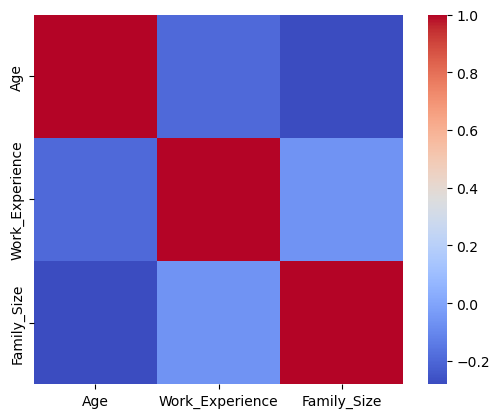

In [7]:
sns.heatmap(data_corr, square = True, cmap = 'coolwarm')

По матрице видно, что между признаками в парах возраст - стаж и возраст - размер семьи существует слабая корреляция, что логично

Гистограммы числовых данных:

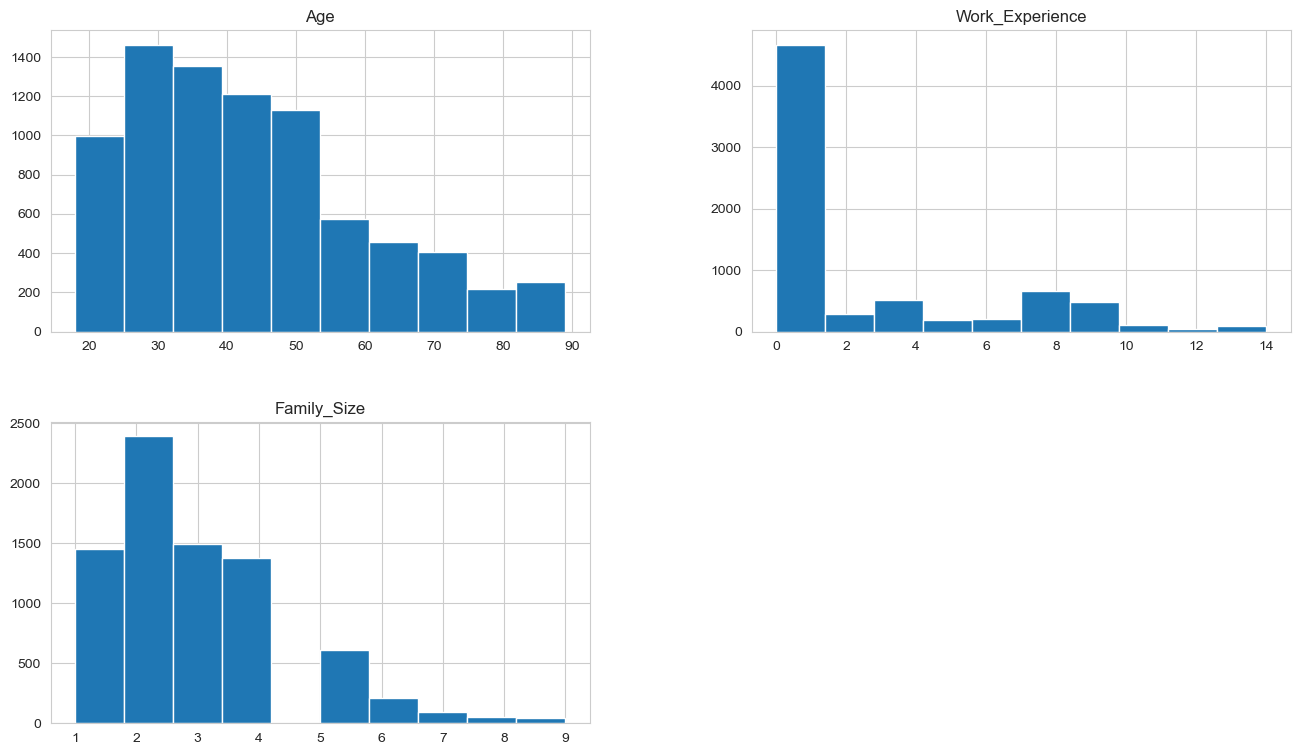

In [8]:
sns.set_style('whitegrid')
numbers = pd.Series(data.columns)
data[numbers].hist(figsize = (16, 9))
plt.show()

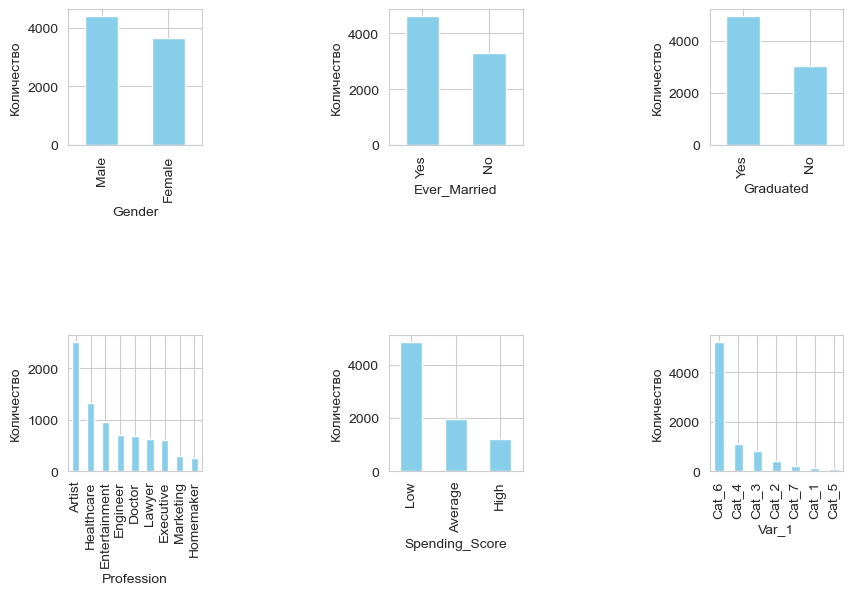

In [9]:
plt.figure(figsize=(10,6))
plt.subplot(3, 5, 1)
data['Gender'].value_counts().plot(kind='bar', color='skyblue')
plt.ylabel("Количество")

plt.subplot(3, 5, 3)
data['Ever_Married'].value_counts().plot(kind='bar', color='skyblue')
plt.ylabel("Количество")

plt.subplot(3, 5, 5)
data['Graduated'].value_counts().plot(kind='bar', color='skyblue')
plt.ylabel("Количество")

plt.subplot(3, 5, 11)
data['Profession'].value_counts().plot(kind='bar', color='skyblue')
plt.ylabel("Количество")

plt.subplot(3, 5, 13)
data['Spending_Score'].value_counts().plot(kind='bar', color='skyblue')
plt.ylabel("Количество")

plt.subplot(3, 5, 15)
data['Var_1'].value_counts().plot(kind='bar', color='skyblue')
plt.ylabel("Количество")
plt.show()

### Вычислить основные характеристики

Описание чистовых данных и их квадратичное отклонение, среднее, минимум, максимум:

In [10]:
data.describe()

,Age,Work_Experience,Family_Size
count,8068.000000,7239.000000,7733.000000
mean,43.466906,2.641663,2.850123
std,16.711696,3.406763,1.531413
min,18.000000,0.000000,1.000000
25%,30.000000,0.000000,2.000000
50%,40.000000,1.000000,3.000000
75%,53.000000,4.000000,4.000000
max,89.000000,14.000000,9.000000


## 3. Обработка пропущенных значений

Заполним пропуски в числовых признаках медианным значением.

In [11]:
data['Work_Experience'].fillna(data['Work_Experience'].median(), inplace=True)
data['Family_Size'].fillna(data['Family_Size'].median(), inplace=True)

Преобразование объектных признаков в категориальные.

In [12]:
data["Gender"] = data["Gender"].astype("category")
data["Ever_Married"] = data["Ever_Married"].astype("category")
data["Graduated"] = data["Graduated"].astype("category")
data["Profession"] = data["Profession"].astype("category")
data["Spending_Score"] = data["Spending_Score"].astype("category")
data["Var_1"] = data["Var_1"].astype("category")
data["Segmentation"] = data["Segmentation"].astype("category")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Gender           8068 non-null   category
 1   Ever_Married     7928 non-null   category
 2   Age              8068 non-null   int64   
 3   Graduated        7990 non-null   category
 4   Profession       7944 non-null   category
 5   Work_Experience  8068 non-null   float64 
 6   Spending_Score   8068 non-null   category
 7   Family_Size      8068 non-null   float64 
 8   Var_1            7992 non-null   category
 9   Segmentation     8068 non-null   category
dtypes: category(7), float64(2), int64(1)
memory usage: 245.8 KB


In [13]:
data["Gender"].dtype, data["Ever_Married"].dtype, data["Graduated"].dtype, data["Profession"].dtype, data["Spending_Score"].dtype, data["Var_1"].dtype, data["Segmentation"].dtype

(CategoricalDtype(categories=['Female', 'Male'], ordered=False, categories_dtype=object),
 CategoricalDtype(categories=['No', 'Yes'], ordered=False, categories_dtype=object),
 CategoricalDtype(categories=['No', 'Yes'], ordered=False, categories_dtype=object),
 CategoricalDtype(categories=['Artist', 'Doctor', 'Engineer', 'Entertainment', 'Executive',
                   'Healthcare', 'Homemaker', 'Lawyer', 'Marketing'],
 , ordered=False, categories_dtype=object),
 CategoricalDtype(categories=['Average', 'High', 'Low'], ordered=False, categories_dtype=object),
 CategoricalDtype(categories=['Cat_1', 'Cat_2', 'Cat_3', 'Cat_4', 'Cat_5', 'Cat_6',
                   'Cat_7'],
 , ordered=False, categories_dtype=object),
 CategoricalDtype(categories=['A', 'B', 'C', 'D'], ordered=False, categories_dtype=object))

Заполним пропуски в категориальных признаках самым частовстречающимся значением, так как таких пропусков было немного, это решение не должно сильно повлиять на ошибку классификации.

In [14]:
data['Ever_Married'].fillna(data['Ever_Married'].value_counts().idxmax(), inplace=True)
data['Graduated'].fillna(data['Graduated'].value_counts().idxmax(), inplace=True)
data['Profession'].fillna(data['Profession'].value_counts().idxmax(), inplace=True)
data['Var_1'].fillna(data['Var_1'].value_counts().idxmax(), inplace=True)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Gender           8068 non-null   category
 1   Ever_Married     8068 non-null   category
 2   Age              8068 non-null   int64   
 3   Graduated        8068 non-null   category
 4   Profession       8068 non-null   category
 5   Work_Experience  8068 non-null   float64 
 6   Spending_Score   8068 non-null   category
 7   Family_Size      8068 non-null   float64 
 8   Var_1            8068 non-null   category
 9   Segmentation     8068 non-null   category
dtypes: category(7), float64(2), int64(1)
memory usage: 245.8 KB


Описание категориальных признаков:

In [16]:
data.describe(include = ['category'])

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
count,8068,8068,8068,8068,8068,8068,8068
unique,2,2,2,9,3,7,4
top,Male,Yes,Yes,Artist,Low,Cat_6,D
freq,4417,4783,5046,2640,4878,5314,2268


## 4. Обработка категориальных признаков

In [17]:
data.columns

Index(['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')

In [18]:
data1 = data.copy()

Присвоение каждому значению в категории своей метки с помощью кодировщика.

In [19]:
from sklearn.preprocessing import LabelEncoder

for i in ['Gender' , 'Ever_Married' , 'Graduated','Profession','Spending_Score','Var_1'  ]:
    le = LabelEncoder()
    data1[i] = le.fit_transform(data1[i].astype('str'))

In [20]:
data1.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,1,0,22,0,5,1.0,2,4.0,3,D
1,0,1,38,1,2,1.0,0,3.0,3,A
2,0,1,67,1,2,1.0,2,1.0,5,B
3,1,1,67,1,7,0.0,1,2.0,5,B
4,0,1,40,1,3,1.0,1,6.0,5,A


## 5. Нормализация числовых значений

Рассмотрим распределение признаков 'Age', 'Work_Experience', 'Family_Size' и их выбросы.

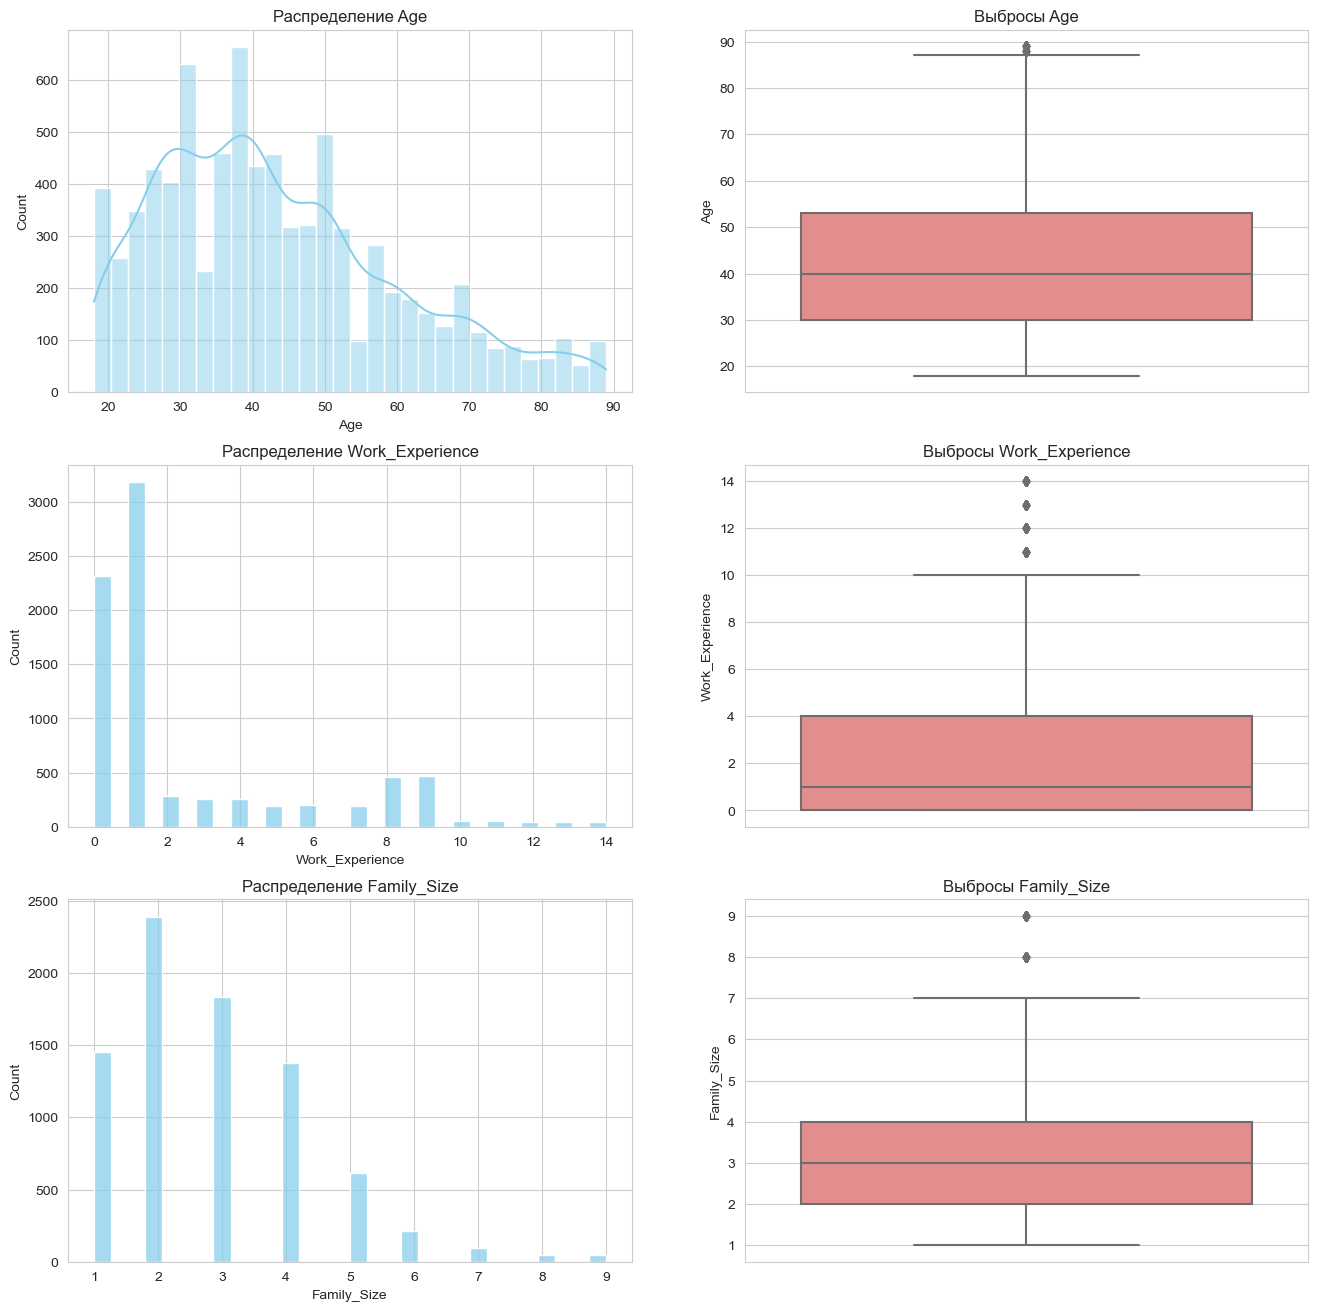

In [21]:
plt.figure(figsize=(16, 16))

plt.subplot(3, 2, 1)
sns.histplot(data['Age'], bins=30, kde=True, color='skyblue')
plt.title('Распределение Age')

plt.subplot(3, 2, 2)
sns.boxplot(y=data['Age'], color='lightcoral')
plt.title('Выбросы Age')

plt.subplot(3, 2, 3)
sns.histplot(data['Work_Experience'], bins=30, color='skyblue')
plt.title('Распределение Work_Experience')

plt.subplot(3, 2, 4)
sns.boxplot(y=data['Work_Experience'], color='lightcoral')
plt.title('Выбросы Work_Experience')

plt.subplot(3, 2, 5)
sns.histplot(data['Family_Size'], bins=30, color='skyblue')
plt.title('Распределение Family_Size')

plt.subplot(3, 2, 6)
sns.boxplot(y=data['Family_Size'], color='lightcoral')
plt.title('Выбросы Family_Size')
plt.show()

Распределение Work Experience явно тяготеет к меньшим значениям, логарифмируем значения этого признака чтобы приблизить форму распределения к нормальной и избавиться от выбросов.

In [22]:
data1['Work_Experience'] = np.log1p(np.abs(data1['Work_Experience']))

Теперь применим standardScaler ко всем числовым признакам

In [23]:
scaler= StandardScaler()
data1[['Age','Work_Experience','Family_Size']]  = scaler.fit_transform(data1[['Age','Work_Experience','Family_Size']])

In [24]:
scaler= RobustScaler()
data1[['Age','Work_Experience','Family_Size']]  = scaler.fit_transform(data1[['Age','Work_Experience','Family_Size']])
data1

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,1,0,-0.782609,0,5,0.000000,2,0.5,3,D
1,0,1,-0.086957,1,2,0.000000,0,0.0,3,A
2,0,1,1.173913,1,2,0.000000,2,-1.0,5,B
3,1,1,1.173913,1,7,-0.430677,1,-0.5,5,B
4,0,1,0.000000,1,3,0.000000,1,1.5,5,A
...,...,...,...,...,...,...,...,...,...,...
8063,1,0,-0.782609,0,0,-0.430677,2,2.0,0,D
8064,1,0,-0.217391,0,4,0.430677,2,0.5,3,D
8065,0,0,-0.304348,1,5,0.000000,2,-1.0,5,D
8066,0,0,-0.565217,1,5,0.000000,2,0.5,5,B


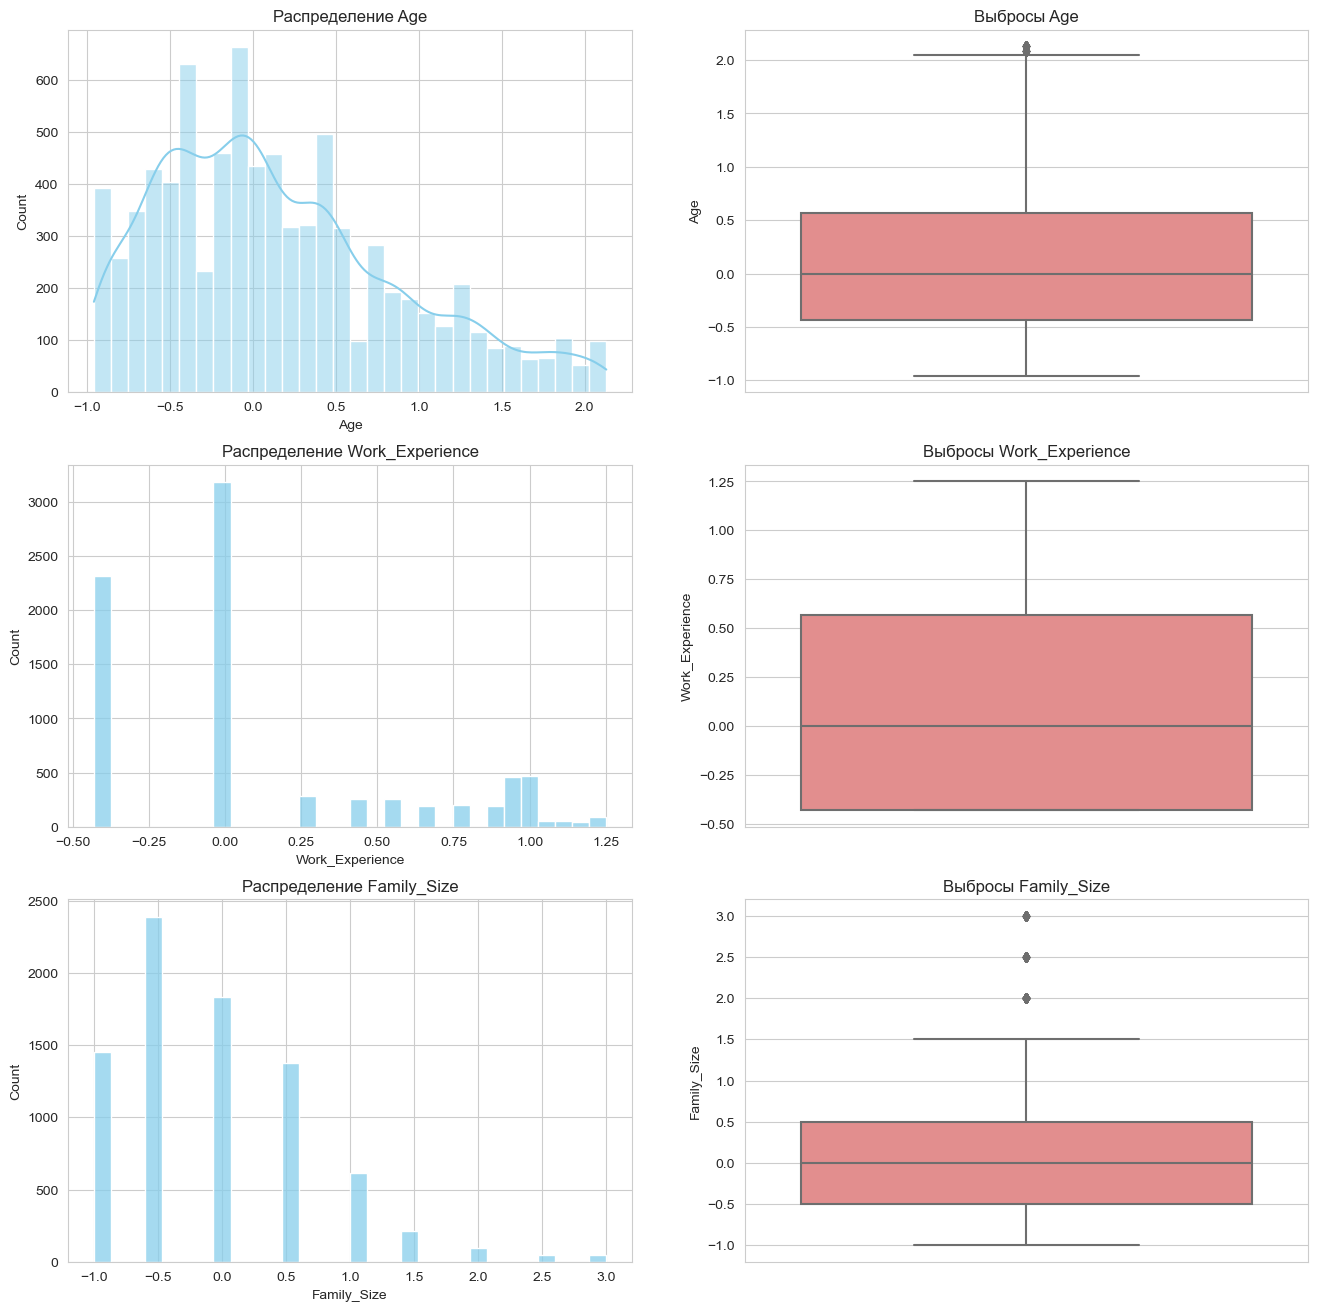

In [25]:
plt.figure(figsize=(16, 16))

plt.subplot(3, 2, 1)
sns.histplot(data1['Age'], bins=30, kde=True, color='skyblue')
plt.title('Распределение Age')

plt.subplot(3, 2, 2)
sns.boxplot(y=data1['Age'], color='lightcoral')
plt.title('Выбросы Age')

plt.subplot(3, 2, 3)
sns.histplot(data1['Work_Experience'], bins=30, color='skyblue')
plt.title('Распределение Work_Experience')

plt.subplot(3, 2, 4)
sns.boxplot(y=data1['Work_Experience'], color='lightcoral')
plt.title('Выбросы Work_Experience')

plt.subplot(3, 2, 5)
sns.histplot(data1['Family_Size'], bins=30, color='skyblue')
plt.title('Распределение Family_Size')

plt.subplot(3, 2, 6)
sns.boxplot(y=data1['Family_Size'], color='lightcoral')
plt.title('Выбросы Family_Size')
plt.show()

## 6. Разделение данных на обучающую и тестовую выборки
Соотношение размеров обучающеи выборки к тестовой = 7 / 3

In [26]:
y = data1['Segmentation']
x = data1.drop(['Segmentation'], axis = 1)

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size = 0.3, random_state = 42)

In [27]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5647 entries, 5015 to 7270
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           5647 non-null   int32  
 1   Ever_Married     5647 non-null   int32  
 2   Age              5647 non-null   float64
 3   Graduated        5647 non-null   int32  
 4   Profession       5647 non-null   int32  
 5   Work_Experience  5647 non-null   float64
 6   Spending_Score   5647 non-null   int32  
 7   Family_Size      5647 non-null   float64
 8   Var_1            5647 non-null   int32  
dtypes: float64(3), int32(6)
memory usage: 308.8 KB


## 7. Запуск KNN

0.0414379316451213 0.5584469227591904
Accuracy Score train : 95.85620683548787
Accuracy Score test : 44.15530772408096


<Figure size 800x600 with 0 Axes>

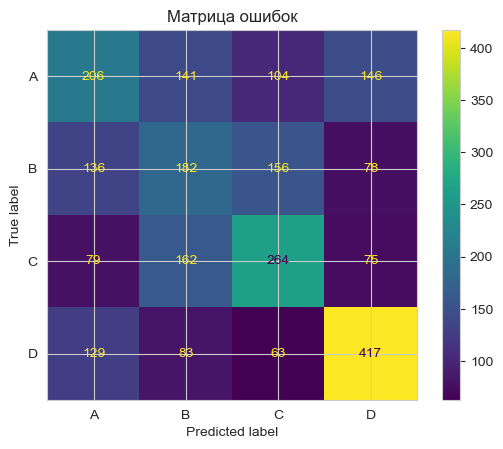

In [28]:
model = KNeighborsClassifier(n_neighbors = 1)
model.fit(x_train, y_train)
y_train_predict = model.predict(x_train)
y_test_predict  = model.predict(x_test)

print(np.mean(y_train != y_train_predict), np.mean(y_test != y_test_predict))
print(f'Accuracy Score train : {accuracy_score(y_train, y_train_predict)*100}')
print(f'Accuracy Score test : {accuracy_score(y_test, y_test_predict)*100}')
plt.figure(figsize = (8, 6))

confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_test_predict)
confusion_matrix_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=model.classes_)
confusion_matrix_display.plot()
plt.title('Матрица ошибок')
plt.show()

## 8. Подбор гиперпараметра KNN с наименьшей ошибкой на тесте.

In [29]:
neighbours = [1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 30]
errs_train = []
errs_test = []

for i in neighbours:
    model = KNeighborsClassifier(n_neighbors = i)
    model.fit(x_train, y_train)
    y_train_predict = model.predict(x_train)
    y_test_predict  = model.predict(x_test)
    errs_train.append(np.mean(y_train != y_train_predict))
    errs_test.append(np.mean(y_test != y_test_predict))

mat = pd.DataFrame([errs_train, errs_test], columns = neighbours,index=["errs_train", "errs_test"])
mat

,1,2,3,4,5,7,10,15,20,25,30
errs_train,0.041438,0.285461,0.313441,0.336816,0.365681,0.389587,0.411192,0.428369,0.437400,0.443598,0.445900
errs_test,0.558447,0.584469,0.531185,0.533664,0.528294,0.509294,0.510533,0.496489,0.490706,0.483684,0.488228


<p>Лучший результат при n_neighbours = 25

              precision    recall  f1-score   support

           A       0.44      0.43      0.43       597
           B       0.41      0.32      0.36       552
           C       0.52      0.55      0.53       580
           D       0.63      0.72      0.67       692

    accuracy                           0.52      2421
   macro avg       0.50      0.50      0.50      2421
weighted avg       0.51      0.52      0.51      2421

0.44359837081636266 0.4836844279223461
Accuracy Score train : 55.640162918363735
Accuracy Score test : 51.63155720776539


<Figure size 800x600 with 0 Axes>

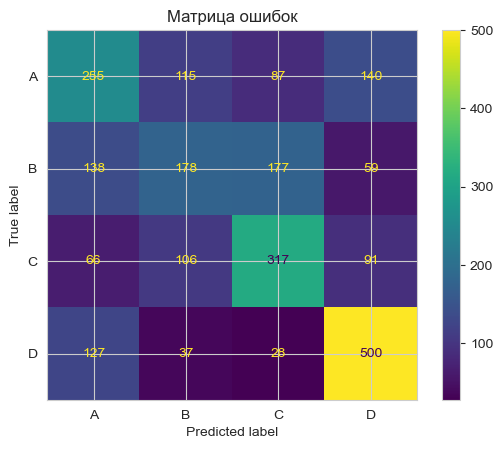

In [30]:
model = KNeighborsClassifier(n_neighbors = 25)
model.fit(x_train, y_train)
y_train_predict = model.predict(x_train)
y_test_predict  = model.predict(x_test)
print(classification_report(y_test, y_test_predict))

print(np.mean(y_train != y_train_predict), np.mean(y_test != y_test_predict))
print(f'Accuracy Score train : {accuracy_score(y_train, y_train_predict)*100}')
print(f'Accuracy Score test : {accuracy_score(y_test, y_test_predict)*100}')
plt.figure(figsize = (8, 6))

confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_test_predict)
confusion_matrix_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=model.classes_)
confusion_matrix_display.plot()
plt.title('Матрица ошибок')
plt.show()

<p>Как оказалось, с такими данными обычный классификатор определяет правильный класс примерно в половине случаев.

## 9. Вычислить ошибки на обучающей и тестовой выборках. Сделать выводы

Заметно, что классификатор считает целевой сегмент А похожим на классы B и D, а сегмент B схожим с классами A и C

Метод был протестирован с различными значениями параметра k. Определение класса по ближайшему соседу при k = 1 показало точность классификации ~96% на обучающей выборке и ~44% на тестовой выборке, что свидетельствует о сильном переобучении. При увеличении числа соседей уже с k = 2 наблюдается прогресс обобщающей способности модели. С увеличением k до 25 было получено оптимальное значение параметра, и точность классификации составила ~55% на обучающей выборке и ~50,5% на тестовой выборке.

## 10. Запуск Light Gradient Boosted Machine

In [31]:
lgbm = LGBMClassifier(max_depth=3)
lgbm.fit(x_train, y_train.ravel())
y_train_predict = lgbm.predict(x_train)
y_test_predict = lgbm.predict(x_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 116
[LightGBM] [Info] Number of data points in the train set: 5647, number of used features: 9
[LightGBM] [Info] Start training from score -1.412671
[LightGBM] [Info] Start training from score -1.464155
[LightGBM] [Info] Start training from score -1.401821
[LightGBM] [Info] Start training from score -1.276234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

              precision    recall  f1-score   support

           A       0.45      0.45      0.45       597
           B       0.46      0.35      0.39       552
           C       0.56      0.58      0.57       580
           D       0.64      0.75      0.69       692

    accuracy                           0.54      2421
   macro avg       0.53      0.53      0.53      2421
weighted avg       0.53      0.54      0.53      2421

0.422879404993802 0.4576621230896324
Accuracy Score train : 57.712059500619795
Accuracy Score test : 54.23378769103676


<Figure size 800x600 with 0 Axes>

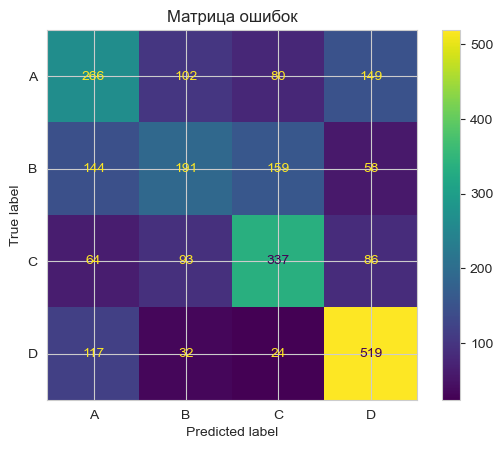

In [32]:
print(classification_report(y_test, y_test_predict))
print(np.mean(y_train != y_train_predict), np.mean(y_test != y_test_predict))
print(f'Accuracy Score train : {accuracy_score(y_train, y_train_predict)*100}')
print(f'Accuracy Score test : {accuracy_score(y_test, y_test_predict)*100}')
plt.figure(figsize = (8, 6))

confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_test_predict)
confusion_matrix_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=model.classes_)
confusion_matrix_display.plot()
plt.title('Матрица ошибок')
plt.show()

LGBM классификатор с оптимальными гиперпараметрами показал результат на 3% лучше, чем KNN, улучшив отклик по B и D классам, но уменьшив по A.

## 11. Устранение дисбаланса классов

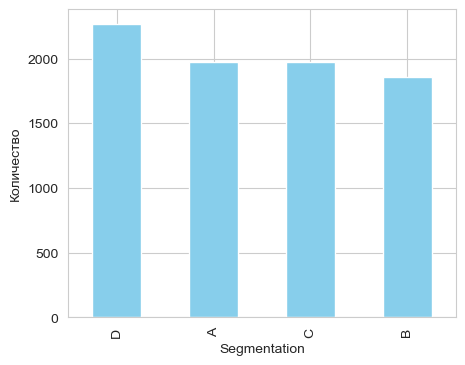

In [33]:
plt.figure(figsize=(5,4))
data['Segmentation'].value_counts().plot(kind='bar', color='skyblue')
plt.ylabel("Количество")
plt.show()

Видно, что в выборке преобладает класс D, хоть и не сильно. Попробуем устранить дисбаланс классов и посмотрим улучшится ли точность предсказания.

In [34]:
print('До применения метода кол-во меток со значением A: {}'.format(sum(y_train == 'A')))
print('До применения метода кол-во меток со значением B: {}'.format(sum(y_train == 'B')))
print('До применения метода кол-во меток со значением C: {}'.format(sum(y_train == 'C')))
print('До применения метода кол-во меток со значением D: {}'.format(sum(y_train == 'D')))

nm = NearMiss()
x_train_miss, y_train_miss = nm.fit_resample(x_train, y_train.ravel())

print('После применения метода кол-во меток со значением A: {}'.format(sum(y_train_miss == 'A')))
print('После применения метода кол-во меток со значением B: {}'.format(sum(y_train_miss == 'B')))
print('После применения метода кол-во меток со значением C: {}'.format(sum(y_train_miss == 'C')))
print('После применения метода кол-во меток со значением D: {}'.format(sum(y_train_miss == 'D')))

До применения метода кол-во меток со значением A: 1375
До применения метода кол-во меток со значением B: 1306
До применения метода кол-во меток со значением C: 1390
До применения метода кол-во меток со значением D: 1576
После применения метода кол-во меток со значением A: 1306
После применения метода кол-во меток со значением B: 1306
После применения метода кол-во меток со значением C: 1306
После применения метода кол-во меток со значением D: 1306


              precision    recall  f1-score   support

           A       0.43      0.44      0.44       597
           B       0.39      0.34      0.37       552
           C       0.52      0.54      0.53       580
           D       0.64      0.68      0.66       692

    accuracy                           0.51      2421
   macro avg       0.50      0.50      0.50      2421
weighted avg       0.51      0.51      0.51      2421

0.449265096511422 0.4886410574142916
Accuracy Score train : 55.0734903488578
Accuracy Score test : 51.135894258570836


<Figure size 800x600 with 0 Axes>

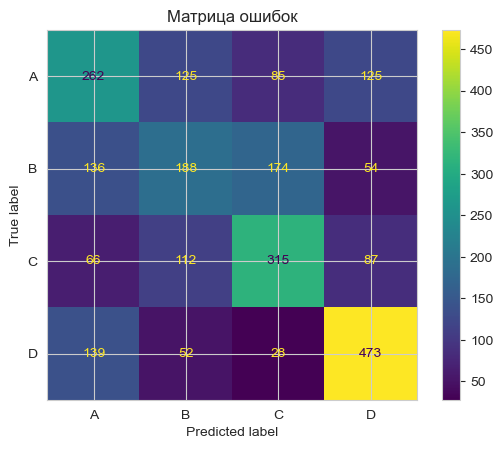

In [35]:
model = KNeighborsClassifier(n_neighbors = 25)
model.fit(x_train_miss, y_train_miss.ravel())
y_train_predict = model.predict(x_train)
y_test_predict = model.predict(x_test)
print(classification_report(y_test, y_test_predict))

print(np.mean(y_train != y_train_predict), np.mean(y_test != y_test_predict))
print(f'Accuracy Score train : {accuracy_score(y_train, y_train_predict)*100}')
print(f'Accuracy Score test : {accuracy_score(y_test, y_test_predict)*100}')
plt.figure(figsize = (8, 6))

confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_test_predict)
confusion_matrix_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=model.classes_)
confusion_matrix_display.plot()
plt.title('Матрица ошибок')
plt.show()

In [36]:
lgbm = LGBMClassifier(max_depth=3, num_leaves=2**3)
lgbm.fit(x_train_miss, y_train_miss.ravel())
y_train_predict = lgbm.predict(x_train)
y_test_predict = lgbm.predict(x_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 116
[LightGBM] [Info] Number of data points in the train set: 5224, number of used features: 9
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

              precision    recall  f1-score   support

           A       0.43      0.46      0.44       597
           B       0.40      0.35      0.37       552
           C       0.57      0.57      0.57       580
           D       0.65      0.68      0.66       692

    accuracy                           0.52      2421
   macro avg       0.51      0.51      0.51      2421
weighted avg       0.52      0.52      0.52      2421

0.43049406764653797 0.4774886410574143
Accuracy Score train : 56.950593235346204
Accuracy Score test : 52.251135894258574


<Figure size 800x600 with 0 Axes>

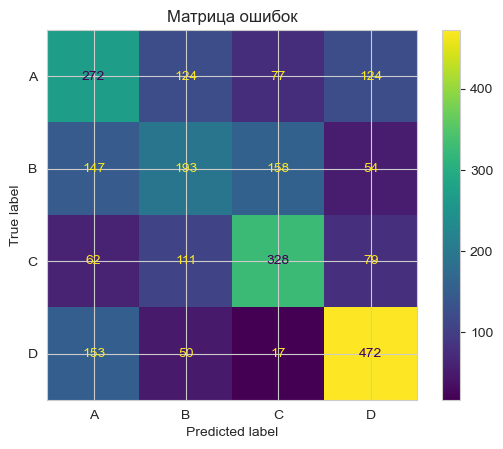

In [37]:
print(classification_report(y_test, y_test_predict))
print(np.mean(y_train != y_train_predict), np.mean(y_test != y_test_predict))
print(f'Accuracy Score train : {accuracy_score(y_train, y_train_predict)*100}')
print(f'Accuracy Score test : {accuracy_score(y_test, y_test_predict)*100}')

plt.figure(figsize = (8, 6))

confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_test_predict)
confusion_matrix_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=model.classes_)
confusion_matrix_display.plot()
plt.title('Матрица ошибок')
plt.show()

На сбалансированной выборке оба классификатора улучшили отклик по B классу. Однако KNN классификатор улучшил общую точность предсказаний на такой выборке, в отличие от LGBDM классификатора.

## 12. Общие выводы

Реализованы и сравнены модели k ближайших соседей и градиентного бустинга. Метод KNN при оптимальном числе соседей k=25 показал точность 0.55 на обучающей и 0.516 на тестовой выборках, демонстрируя хорошее обобщение. Градиентный бустинг с оптимальными гиперпараметрами дал точность 0.58 на обучающей и 0.54 на тестовой выборках, демонстрируя лучший результат как по общему числу правильных предсказаний, так и по отклику отдельных классов. Как оказалось, на этом наборе данных оба классификатора определяют правильный класс примерно в половине случаев. Можно также заметить, что LGBDM модель лучше различал миногные классы B и C с откликом на ~0.05 выше чем KNN. При попытке дополнительно сбалансировать классы улучшились отклики по минорным классам у всех моделей, Однако KNN классификатор улучшил общую точность предсказаний на такой выборке, в отличие от LGBDM классификатора.

## 1. Применение PCA

Спроецируем данные в двумерное пространство для визуализации. Для этого используется метод главных компонент (PCA), который позволяет уменьшить количество признаков, сохраняя при этом максимум информации о различиях между объектами. Выбираем две компоненты для отображения данных в 2D. Метод fit_transform применяет преобразование к данным, и мы получаем новые данные с двумя признаками для визуализации.

In [38]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

In [39]:
pca = PCA(n_components=2, random_state=42)
X_reduced = pca.fit_transform(X_scaled)

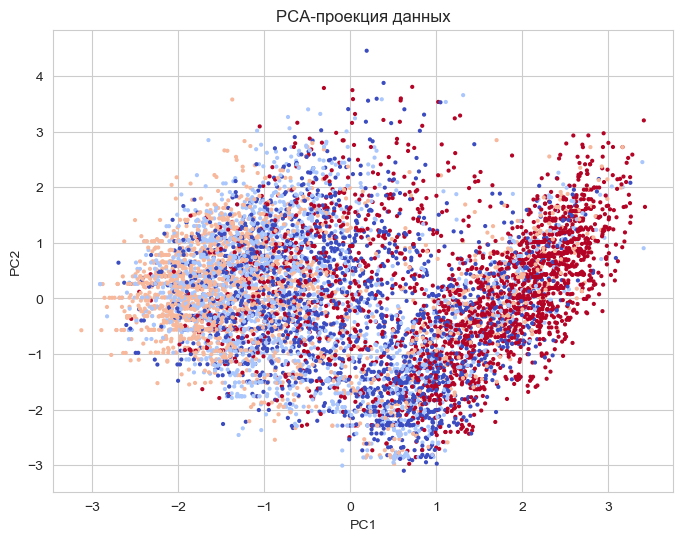

In [40]:
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=[ord(y[i]) - ord('A') for i in range(len(y))], cmap='coolwarm', s=4)
plt.title('PCA-проекция данных')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## 2. Создание и обучение моделей Kmeans, DBSCAN и аггломеративной кластеризации
Для Kmeans и аггломеративной моделей задается количество кластеров - 4.

In [41]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

dbscan = DBSCAN(eps=1.4, min_samples=4)
dbscan_labels = dbscan.fit_predict(X_scaled)

agglo = AgglomerativeClustering(n_clusters=4)
agglo_labels = agglo.fit_predict(X_scaled)

## 3. Оценка ARI результата работы и подсчет силуэта каждой модели

In [42]:
ari_kmeans = adjusted_rand_score(y, kmeans_labels)
ari_dbscan = adjusted_rand_score(y, dbscan_labels)
ari_agglo = adjusted_rand_score(y, agglo_labels)

print(f"ARI for KMeans: {ari_kmeans:.4f}")
print(f"ARI for DBSCAN: {ari_dbscan:.4f}")
print(f"ARI for Agglomerative Clustering: {ari_agglo:.4f}")

ARI for KMeans: 0.1140
ARI for DBSCAN: 0.0644
ARI for Agglomerative Clustering: 0.0828


In [43]:
dbscan_labels_filtered = dbscan_labels[dbscan_labels != -1]
X_scaled_filtered = X_scaled[dbscan_labels != -1]

silhouette_kmeans = silhouette_score(X_scaled, kmeans_labels)
silhouette_dbscan = silhouette_score(X_scaled_filtered, dbscan_labels_filtered)
silhouette_agglo = silhouette_score(X_scaled, agglo_labels)

print(f"Silhouette Score for KMeans: {silhouette_kmeans:.4f}")
print(f"Silhouette Score for DBSCAN: {silhouette_dbscan:.4f}")
print(f"Silhouette Score for Agglomerative Clustering: {silhouette_agglo:.4f}")

Silhouette Score for KMeans: 0.1837
Silhouette Score for DBSCAN: 0.1361
Silhouette Score for Agglomerative Clustering: 0.1578


## 4. Визуализация спроектированных на плоскость методом главных компонент кластеров

In [44]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

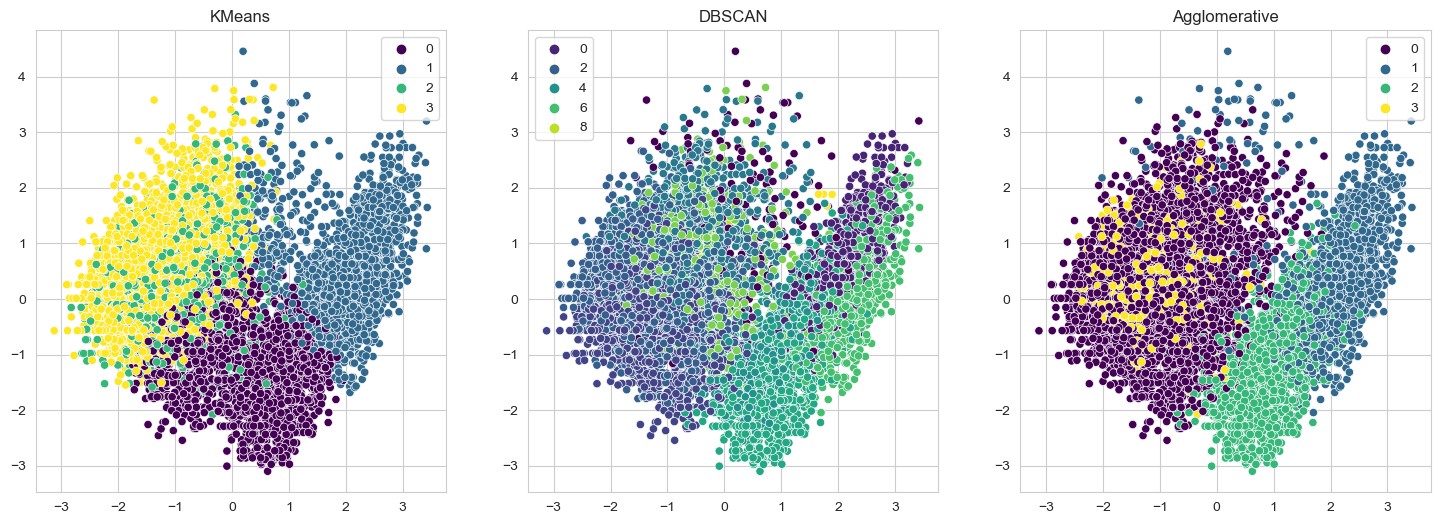

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette="viridis", ax=axs[0])
axs[0].set_title("KMeans")

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=dbscan_labels, palette="viridis", ax=axs[1])
axs[1].set_title("DBSCAN")

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=agglo_labels, palette="viridis", ax=axs[2])
axs[2].set_title("Agglomerative")

plt.show()

На основе полученных результатов можно сделать вывод, что алгоритм KMeans показал наилучшие результаты кластеризации: он имеет самый высокий показатель Silhouette Score (0.1837), что свидетельствует о наиболее чётком разделении кластеров и их внутренней плотности. Значение ARI (0.1140) также является наибольшим среди трёх методов, что указывает на некоторое соответствие истинным меткам. Алгоритмы Agglomerative Clustering и DBSCAN показали более слабые результаты: их Silhouette Score составили 0.1361 и 0.1578 соответственно, а ARI оказался ниже (0.0644 и 0.0828), что говорит о менее выраженных кластерах и возможных ошибках группировки. Таким образом, для данного набора данных метод KMeans оказался наиболее эффективным среди рассмотренных.